In [ ]:
pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 872.3 kB/s eta 0:00:00
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 3.6 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully uninstalled nvidia-nccl-cu12-2.20.5
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
device = torch.device("cpu")
print("Using device:", device)


Using device: cpu


In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import yaml
import matplotlib.pyplot as plt

In [22]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels_dir = os.path.join(self.root_dir, 'labels')
        self.images_dir = os.path.join(self.root_dir, 'images')
        self.image_files = [f for f in os.listdir(self.images_dir) if os.path.isfile(os.path.join(self.images_dir, f))]
        self.label_files = [f for f in os.listdir(self.labels_dir) if os.path.isfile(os.path.join(self.labels_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        label_name = os.path.join(self.labels_dir, self.label_files[idx])

        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        with open(label_name, 'r') as file:
            line = file.readline().strip()
            label = int(line.split()[0])

        return image, label

In [23]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True),
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True),
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        outputs = [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)]
        return torch.cat(outputs, 1)

In [24]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes):
        super(GoogleNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(480, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [25]:
with open('/content/drive/MyDrive/CSE 575 Project/archive/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

In [26]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(root_dir='/content/drive/MyDrive/CSE 575 Project/archive/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomDataset(root_dir='/content/drive/MyDrive/CSE 575 Project/archive/valid', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = CustomDataset(root_dir='/content/drive/MyDrive/CSE 575 Project/archive/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

In [27]:
model = GoogleNet(data['nc'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
inception_train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        # logits = outputs.logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    inception_train_accuracies.append(epoch_accuracy)

    print(f"Epoch: {epoch}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch: 0/20, Training Loss: 1.7123, Accuracy: 0.5207
Epoch: 1/20, Training Loss: 1.3541, Accuracy: 0.6391
Epoch: 2/20, Training Loss: 1.2644, Accuracy: 0.6302
Epoch: 3/20, Training Loss: 1.2349, Accuracy: 0.6272
Epoch: 4/20, Training Loss: 1.2233, Accuracy: 0.6479
Epoch: 5/20, Training Loss: 1.2110, Accuracy: 0.6509
Epoch: 6/20, Training Loss: 1.1746, Accuracy: 0.6479
Epoch: 7/20, Training Loss: 1.1935, Accuracy: 0.6479
Epoch: 8/20, Training Loss: 1.1253, Accuracy: 0.6598
Epoch: 9/20, Training Loss: 1.1310, Accuracy: 0.6479
Epoch: 10/20, Training Loss: 1.0995, Accuracy: 0.6450
Epoch: 11/20, Training Loss: 1.1030, Accuracy: 0.6509
Epoch: 12/20, Training Loss: 1.0611, Accuracy: 0.6361
Epoch: 13/20, Training Loss: 1.0337, Accuracy: 0.6746
Epoch: 14/20, Training Loss: 1.0276, Accuracy: 0.6775
Epoch: 15/20, Training Loss: 1.0450, Accuracy: 0.6686
Epoch: 16/20, Training Loss: 1.0410, Accuracy: 0.6805
Epoch: 17/20, Training Loss: 0.9632, Accuracy: 0.6864
Epoch: 18/20, Training Loss: 0.9418, A

In [29]:
import time

model.eval()
correct = 0
total = 0
total_inference_time = 0  # Initialize total inference time
num_batches = 0  # Counter for the number of batches processed

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to('cpu')

        start_time = time.time()
        outputs = model(images)
        inference_time = time.time() - start_time

        total_inference_time += inference_time
        num_batches += 1

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = (100 * correct / total) if total > 0 else 0
print(f"Accuracy on test set: {accuracy:.2f}%")

average_inference_time = total_inference_time / num_batches if num_batches > 0 else 0
print(f"Average inference time per batch (CPU): {average_inference_time:.4f} seconds")



Accuracy on test set: 21.88%
Average inference time per batch (CPU): 2.7310 seconds


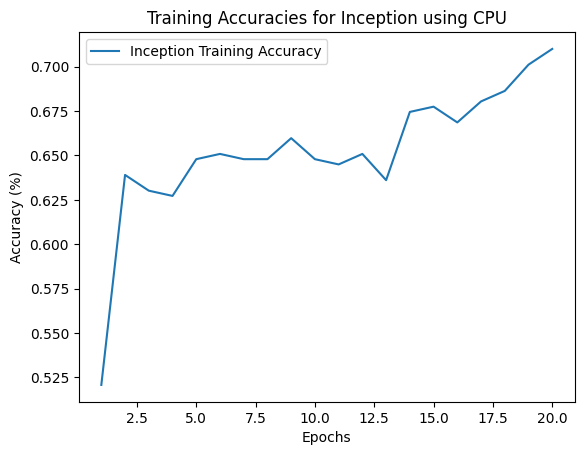

In [30]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, inception_train_accuracies, label='Inception Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracies for Inception using CPU')
plt.legend()
plt.show()